Now it is time to make the model for to predict housing prices based off all the data we have gathered.

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.cluster import AgglomerativeClustering

from imblearn.over_sampling import RandomOverSampler

from sklearn.metrics import confusion_matrix

# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

Lets read the test and train csvs and store them in their respective variables.  As you can see, the data has all the features we have developed, but no date.

In [12]:
train = pd.read_csv('train.csv') # import training data
test = pd.read_csv('test.csv') # import testing data
train.head()

,address,Price,propertyLng,propertyLat,T_Detached,T_Semi-Detached,T_other,Utilities,Rooms,Bathrooms,...,within_learning centre,#_of_learning centre_within,within_university,#_of_university_within,within_subway_station,#_of_subway_station_within,within_cemetery,#_of_cemetery_within,within_green_space,#_of_green_space_within
0,38-bellefontaine-street,1250000.0,-79.2910,43.7988,True,False,False,3.0,10.0,6.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,728-conacher-drive,1357500.0,-79.4009,43.8011,True,False,False,3.0,12.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,287-strathallan-wood,1165000.0,-79.4276,43.7114,True,False,False,3.0,8.5,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,277-highfield-road,453000.0,-79.3252,43.6731,False,True,False,3.0,6.5,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,139-kingsview-boulevard,498000.0,-79.5637,43.6962,True,False,False,3.0,9.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


As we saw in our analysis, there are some outliers which will throw off our regression model, lets develop a function to filter these out.

In [13]:
def clean_data(data):
    data = data[data['Size'] < 1000] # filter out size greater than 1000
    data = data[data['Rooms'] > 0] # filter out rooms = 0
    data = data[data['Bedrooms'] > 0] # filter out bedrooms = 0
    data = data[(data['Price'] / data['Cuml Inflation']) <= 3000000] # filter out price > 3,000,000
    
    return data

Lets also come up with a function to select the features we want to use. This is based off the analysis we did (for instance the fronting direction had no impact), but is also including as many features as possible so we can compare how our model does with and without certain features. Lets make a couple of these so we can compare how different feature perform.

In [14]:
# All features for our final model
def feature_engineering(data):

    feature_selected = ['Size', 'T_Detached', 'T_Semi-Detached', 'T_other', 'Utilities', 'Rooms', 'Bathrooms',
                       'Kitchens', 'Bedrooms', 'Parking', 'Fireplace', 'Feature', 'Pool', 'Interest %', 'Delta',
                       'Population', 'crime_density_per_cap', 'crime_density', 'Neighb_pop', 'Raw Inflation',
                       'Education investment in area', 'Transportation investment in area', 'Unemployment',
                        'Colleges/Universities investment in area', 'propertyLng', 'propertyLat',
                       'within_academy', '#_of_academy_within', 'within_education_centres', 
                        '#_of_education_centres_within', 'within_highschool', '#_of_highschool_within',
                        'within_elementary school', '#_of_elementary school_within', 'within_college',
                        '#_of_college_within', 'within_learning centre', '#_of_learning centre_within',
                        'within_university', '#_of_university_within', 'within_subway_station',
                        '#_of_subway_station_within', 'within_cemetery', '#_of_cemetery_within', 'within_green_space'
                        , '#_of_green_space_within']
    
    return data[feature_selected]

In [15]:
# only the features from the housing database
def feature_houses(data):

    feature_selected = ['Size', 'T_Detached', 'T_Semi-Detached', 'T_other', 'Utilities', 'Rooms', 'Bathrooms',
                       'Kitchens', 'Bedrooms', 'Parking', 'Fireplace', 'Feature', 'Pool']
    
    return data[feature_selected]

In [16]:
# only the features from the housing database with financial features
def feature_financial(data):

    feature_selected = ['Size', 'T_Detached', 'T_Semi-Detached', 'T_other', 'Utilities', 'Rooms', 'Bathrooms',
                       'Kitchens', 'Bedrooms', 'Parking', 'Fireplace', 'Feature', 'Pool', 'Interest %',
                        'Delta', 'Raw Inflation', 'Population', 'Unemployment']
    
    return data[feature_selected]

In [17]:
# only the features from the housing database with crime data features
def feature_crime(data):

    feature_selected = ['Size', 'T_Detached', 'T_Semi-Detached', 'T_other', 'Utilities', 'Rooms', 'Bathrooms',
                       'Kitchens', 'Bedrooms', 'Parking', 'Fireplace', 'Feature', 'Pool', 'crime_density_per_cap',
                        'crime_density']
    
    return data[feature_selected]

In [18]:
# only the features from the housing database with nearby infrastructure features
def feature_infrastructure(data):

    feature_selected = ['Size', 'T_Detached', 'T_Semi-Detached', 'T_other', 'Utilities', 'Rooms', 'Bathrooms',
                       'Kitchens', 'Bedrooms', 'Parking', 'Fireplace', 'Feature', 'Pool', 
                        'within_academy', '#_of_academy_within', 'within_education_centres', 
                        '#_of_education_centres_within', 'within_highschool', '#_of_highschool_within',
                        'within_elementary school', '#_of_elementary school_within', 'within_college',
                        '#_of_college_within', 'within_learning centre', '#_of_learning centre_within',
                        'within_university', '#_of_university_within', 'within_subway_station',
                        '#_of_subway_station_within', 'within_cemetery', '#_of_cemetery_within',
                        'within_green_space', '#_of_green_space_within']
    
    return data[feature_selected]

Now, we will see how a random forest regression model performs on this data

In [19]:
def simple_model(data, features):
    # define X and y
    X = features(clean_data(data))
    y = clean_data(data)['Price'] / clean_data(data)['Cuml Inflation']

    # Split into train and val
    X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state = 42)

    # Create model
    simple_model = RandomForestRegressor(n_estimators = 100, max_depth = 25, max_features = 0.8, max_samples= 0.9)

    # Run Cross validation
    rmse = np.median((-cross_val_score(simple_model, X, y, scoring = 'neg_root_mean_squared_error', cv = 5)))
    
    return rmse, simple_model
# print results
rmse, simple_model = simple_model(train, feature_engineering) # fit the model on the train data

print(rmse)
 # print out the statistics of the price
print((clean_data(train)['Price'] / clean_data(train)['Cuml Inflation']).describe())

202689.03312140232
count    2.310300e+04
mean     8.720413e+05
std      4.577874e+05
min      1.924719e+05
25%      5.629573e+05
50%      7.399164e+05
75%      1.043187e+06
max      2.998930e+06
dtype: float64


We get a root mean squared error of about 260,000 dollars. So on average we are 260,000 dollars off for each house. That is much better than the standard deviation (or what a model predicting the average price for each house would get) of 482,000 dollars, but still seems a bit unreliable. For a house worth 2,000,000 dollars, being off by 260,000 dollars would be ok, but if the house is worth 600,000 dollars, our model is not very useful.

Lets create a function to bin our data based into different price points (low, medium, or high). We can have one model to predict the price category, and then apply our regression model for each price category.

In [20]:
def bin_data(data):
    """This function splits data into ['Low', 'Medium', 'High'] price points"""
    
    # Split the data into three groups based off their price
    quartiles = (data['Price'] / data['Cuml Inflation']).quantile([0.33, 0.71])

    # Define the price ranges
    bins = [0, quartiles[0.33], quartiles[0.71], float('inf')]
    labels = ['Low', 'Medium', 'High']

    # Categorize each property
    data['Price_Category'] = pd.cut(data['Price'] / data['Cuml Inflation'], bins=bins, labels=labels)
    
    return data

Lets run a grid search to look for the best percentile ranges to split our data at.

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

def grid_search_price_splits_adjusted(data, percentile_ranges, random_state=42):
    best_accuracy = 0
    best_split = None

    for percentile_1 in percentile_ranges:
        for percentile_2 in percentile_ranges:
            if percentile_2 > percentile_1:
          # Calculate the quantiles
                quartiles = (data['Price'] / data['Cuml Inflation']).quantile([percentile_1, percentile_2])

                # Define the price ranges
                bins = [0, quartiles[percentile_1], quartiles[percentile_2], float('inf')]
                labels = ['Low', 'Medium', 'High']

                # Categorize each property
                data['Price_Category'] = pd.cut(data['Price'], bins=bins, labels=labels)

                # Preprocessing the data
                X = feature_engineering(clean_data(data))
                y = clean_data(data)['Price_Category']

                # Splitting the data
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

                # Training the Random Forest Classifier with class weights
                class_weights = 'balanced'
                rf_classifier = RandomForestClassifier(random_state=random_state, class_weight=class_weights)
                rf_classifier.fit(X_train, y_train)

                # Predicting and Evaluating
                y_pred = rf_classifier.predict(X_test)
                accuracy = accuracy_score(y_test, y_pred)

                conf_matrix = confusion_matrix(y_test, y_pred, labels=labels)

                # Calculating category-specific accuracy
                accuracy_per_category = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
                
                category_accuracy = dict(zip(['Low', 'Medium', 'High'], accuracy_per_category))
                
                accuracy = np.mean(list(category_accuracy.values()))

                # Check if this is the best accuracy
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_split = (percentile_1, percentile_2)
                    


    return best_split, best_accuracy

# Example percentile ranges (for demonstration, using a small range)
percentile_ranges = [0.30, 0.31, 0.33, 0.34, 0.35, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71]

# Assuming 'train_data' is the DataFrame
best_split, best_accuracy = grid_search_price_splits_adjusted(train, percentile_ranges)
best_split, best_accuracy

((0.33, 0.71), 0.8021675206704644)

We also need a function to split our data into X_train, X_val, y_train, y_val

In [21]:
def split_data(data, features):
    """Takes in a data set, filters by features and returns the following parameters:
    X_train, X_val, y_train, y_val, X, y, where X are the given values, and y is the target data."""
    # Splitting the data into features (X) and target (y)
    X = features(clean_data(data))

    y = clean_data(data)['Price_Category']

    # Splitting the data into training and testing sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    return (X_train, X_val, y_train, y_val, X, y)

Now we can create a function which will train a random forrest classifier to help determine what price category each house should be in

In [22]:
def classify_price(data, X_train, y_train, X, features):
    """ This function takes in data, an X_train dataframe, a y_train series, the whole data set of features (X),
    and the features. It returns a data set with the predicted Category"""
    # clean the data
    data = clean_data(data)
    
    # Training the Random Forest Classifier with class weights
    class_weights = 'balanced'
    rf_classifier = RandomForestClassifier(random_state=42, class_weight=class_weights, 
                                          n_estimators = 50, max_depth = 25, max_features = 0.75, max_samples= 0.75)
    rf_classifier.fit(X_train, y_train)

    y_pred = rf_classifier.predict(features(X))
    
    # Add predicted classes to the original dataset
    data['Category'] = y_pred
    return data, rf_classifier

Lets test how the classification is working

In [23]:
train_temp = bin_data(train)
X_train, X_val, y_train, y_val, X, y = split_data(train, feature_engineering)
temp_data, rf_classifier = (classify_price(train_temp, X_val, y_val, X, feature_engineering))
y_pred = temp_data['Category']

# Generating the confusion matrix
conf_matrix = confusion_matrix(y, y_pred, labels = ['Low', 'Medium', 'High'])

# Calculating category-specific accuracy
accuracy_per_category = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)

# Mapping category names to their accuracies
category_accuracy = dict(zip(['Low', 'Medium', 'High'], accuracy_per_category))
category_accuracy

{'Low': 0.853380044115739,
 'Medium': 0.7967379077615299,
 'High': 0.8143252382416231}

Not a bad accuracy for dividing up the label, now we can use these labels to train a random forest regression model. First, lets add these predicted categories to the train set.

Lets do a grid search to find the optimal hyperparameters.

In [38]:
from sklearn.model_selection import GridSearchCV
def grid_search_rf_params(data, category, param_grid, cv_folds=3):
    # Filter the training data for the given category and preprocess
    data = bin_data(data)
    X_train, X_val, y_train, y_val, X, y = split_data(data, feature_engineering)
    data, rf_classifier = classify_price(data, X_train, y_train, X, feature_engineering)
    category_data = data[data['Category'] == category]
    X_category = feature_engineering(category_data)
    y_category = category_data['Price'] / category_data['Cuml Inflation']

    # Initialize the GridSearchCV
    grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=cv_folds, scoring='neg_mean_squared_error', 
                               return_train_score=True, n_jobs=-1)

    # Fit the GridSearchCV
    grid_search.fit(X_category, y_category)
   

    # Best parameters and score
    best_params = grid_search.best_params_
    best_score =grid_search.best_score_  # Convert from negative MSE to positive

    return best_params, best_score

# Example parameter grid (simplified for demonstration)
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, 25],
    'max_features': [0.5, 0.7, 0.8],
    'max_samples': [0.6, 0.9]
}

# Selecting a category for demonstration (e.g., 'Low')
best_params, best_score = grid_search_rf_params(train, 'Low', param_grid)
best_params, best_score

({'max_depth': 10,
  'max_features': 0.5,
  'max_samples': 0.6,
  'n_estimators': 50},
 -6265624037.2593565)

Now we can create a function to run our model on all the price categories.

In [24]:
# Adjusting the function to ensure the 'address' column is excluded
def train_evaluate_regression_model(data, category, features):
    """This function takes in data, a category label, and features and predicts the housing prices.
    It returns the root mean squared error and the mean error."""
    # Filter the training data for the given category
    category_data = clean_data(data[data['Category'] == category])

    # Excluding 'address' and splitting the category data into features and target
    X_category = features(clean_data(category_data))
    
    y_category = category_data['Price'] / category_data['Cuml Inflation']

    # Splitting into training and testing sets
    X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_category,
                                                                        y_category, test_size=0.2, random_state=42)

    # Training the Linear Regression model
    lr_model = RandomForestRegressor(n_estimators = 50, max_depth = 25, max_features = 0.5, max_samples= 0.6)
    lr_model.fit(X_train_cat, y_train_cat)

    # Predicting and evaluating the model
    y_pred_cat = lr_model.predict(X_test_cat)
    rmse = np.median(-cross_val_score(lr_model, X_category, y_category, scoring = 'neg_root_mean_squared_error', 
                            cv = 5))


    return rmse, lr_model

Now we can create a function to run the entire model for any data and features using the functions we have created.

In [25]:
def run_model(data, features):
    """This function takes in data and a features function and returns the rmse and mae for low, medium, and high
    price category houses."""
    data = bin_data(data) # bin the data
    X_train, X_val, y_train, y_val, X, y = split_data(data, features) # split the data
    
    data, rf_classifier = classify_price(data, X_train, y_train, X, features) # classify the data
    
    results_v2 = {} # create an empty dictionary
    
    # this for loop determines the rmse for each price category
    for category in ['Low', 'Medium', 'High']:
        rmse, lr_model = train_evaluate_regression_model(data, category, features)
        results_v2[category] = {'RMSE': rmse}

    return results_v2 

Lets see how our train data performs for all the features

In [26]:
train_model = run_model(train, feature_engineering)
train_model

{'Low': {'RMSE': 60457.75938100103},
 'Medium': {'RMSE': 109700.74327993732},
 'High': {'RMSE': 297049.57415475807}}

How does that compare to the standard deviations?

In [27]:
standard_dev = [] # create empty list for the standard deviations
for category in ['Low', 'Medium', 'High']:
    X_train, X_val, y_train, y_val, X, y = split_data(train, feature_engineering) # split the train data
    
    # categorize the train data
    train, rf_classifier = classify_price(train, X_train, y_train, X, feature_engineering)
    
    category_data = clean_data(train[train['Category'] == category]) # select category data
    standard_dev.append(category_data['Price'].std()) # append to standard_dev list
    print('Standard Deviation of ' + category + ' category: ' + str(category_data['Price'].std())) # print results

Standard Deviation of Low category: 134648.11383479726
Standard Deviation of Medium category: 190431.78929742068
Standard Deviation of High category: 635459.7549026753


Lets see how our model compares to the standard deviation

In [28]:
for i in range(3):
    percentage = standard_dev[i] / pd.DataFrame(train_model).iloc[0,i]
    print(percentage)

2.2271436324037954
1.735920683886997
2.139238060552179


Now it is time to test our data frame. we will test it for all the features, the house features only, the house features + financial features, the house features + the crime features, and the house features + the infrastructure features

In [29]:
def run_model_with_test(train_data, test_data, features):
    """This function takes in train_data, test data and a features function and returns the rmse and mae for low,
    medium, and high price category houses for the test data using a random forrest classification model and a 
    random forrest regression model, trained by the train_data."""
    train_data = bin_data(train_data) # bin data
    X_train, X_val, y_train, y_val, X, y = split_data(train_data, features) # split data
    train_data, rf_classifier = classify_price(train_data, X_train, y_train, X, features) # create classification model
    
    test_data = clean_data(test_data) # clean test data
    
    X_test = features(test_data) # create X_test
    y_test = test_data['Price'] / test_data['Cuml Inflation'] # create y_test
    
    test_data['Category'] = rf_classifier.predict(X_test) # predict categories for test data
    
    
    results_v2 = {}
    for category in ['Low', 'Medium', 'High']:
        rmse, lr_model = train_evaluate_regression_model(train_data, category, features) # train regression model
        
        X_test_cat = X_test[test_data['Category'] == category] # create X test data for the category
        y_test_cat = y_test[test_data['Category'] == category] # create y test data for the category
        
        y_pred = lr_model.predict(X_test_cat) # predict prices
        rmse_test = (mean_squared_error(y_test_cat, y_pred, squared=False)) # calculate mean squared error
        results_v2[category] = {'RMSE': rmse_test} # append to results

    return results_v2   

In [30]:
test_model = run_model_with_test(train, test, feature_engineering)
test_model

{'Low': {'RMSE': 102281.14019328186},
 'Medium': {'RMSE': 157937.7395757243},
 'High': {'RMSE': 338513.37848064257}}

In [31]:
test_model_houses = run_model_with_test(train, test, feature_houses)
test_model_houses

{'Low': {'RMSE': 315774.9231845981},
 'Medium': {'RMSE': 293422.2519502679},
 'High': {'RMSE': 454493.3975262632}}

In [32]:
test_model_financial = run_model_with_test(train, test, feature_financial)
test_model_financial

{'Low': {'RMSE': 202532.36849831144},
 'Medium': {'RMSE': 217518.96114683448},
 'High': {'RMSE': 461346.8945003456}}

In [33]:
test_model_crime = run_model_with_test(train, test, feature_crime)
test_model_crime

{'Low': {'RMSE': 278968.4578675983},
 'Medium': {'RMSE': 249708.42616792955},
 'High': {'RMSE': 431672.4549562836}}

In [34]:
test_model_infrastructure = run_model_with_test(train, test, feature_infrastructure)
test_model_infrastructure

{'Low': {'RMSE': 273825.9687615803},
 'Medium': {'RMSE': 221289.47892150207},
 'High': {'RMSE': 392054.66046949144}}

Lets summarize our data

In [35]:
test_results = pd.concat([pd.DataFrame(test_model), pd.DataFrame(test_model_houses),
                        pd.DataFrame(test_model_financial), pd.DataFrame(test_model_crime),
                        pd.DataFrame(test_model_infrastructure)])

test_results = test_results.reset_index(drop = True)
test_results = test_results.rename(index={0: "Full Model", 1: "Houses Model", 2: "Financial Model", 
                                         3: "Crime Model", 4: 'Infrastructure Model'})
test_results.head()

,Low,Medium,High
Full Model,102281.140193,157937.739576,338513.378481
Houses Model,315774.923185,293422.251950,454493.397526
Financial Model,202532.368498,217518.961147,461346.894500
Crime Model,278968.457868,249708.426168,431672.454956
Infrastructure Model,273825.968762,221289.478922,392054.660469


Now we can make a vizualization to compare how different models influnced the performance

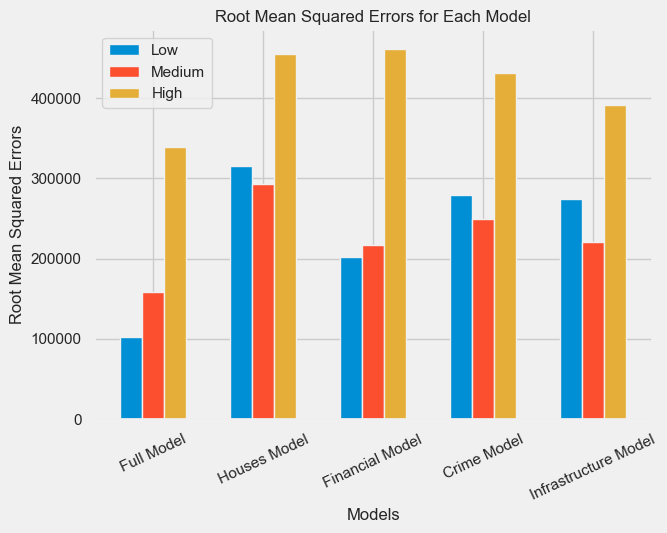

In [36]:
X_axis = np.arange(len(test_results)) # create x-axis length array

Low = list(test_results['Low']) # create low price array
Med = list(test_results['Medium']) # create medium price array
High = list(test_results['High']) # create high price array
  
plt.bar(X_axis - 0.2, Low, 0.2, label = 'Low') 
plt.bar(X_axis, Med, 0.2, label = 'Medium') 
plt.bar(X_axis + 0.2, High, 0.2, label = 'High') 

plt.xticks(X_axis, test_results.index, rotation=25)
plt.xlabel("Models") 
plt.ylabel("Root Mean Squared Errors") 
plt.title("Root Mean Squared Errors for Each Model") 
plt.legend() 
plt.show()

Nice, our full model is performing the best! It seems like the infrastructure has a large influence, while the crime data and financial data on its own does not seem to help our model much.